In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34, resnet50
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import time
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from medmnist import PathMNIST

from eqCLR.eq_resnet import EqResNet18
from evaluation import model_eval, dataset_to_X_y, lin_eval_rep

In [3]:
###################### PARAMS ##############################

BACKBONE = "resnet18"

BATCH_SIZE = 512
N_EPOCHS = 100 # 1000
N_CPU_WORKERS = 16
BASE_LR = 0.03         # important
WEIGHT_DECAY = 5e-4    # important
MOMENTUM = 0.9
PROJECTOR_HIDDEN_SIZE = 1024
PROJECTOR_OUTPUT_SIZE = 128
CROP_LOW_SCALE = 0.2
GRAYSCALE_PROB = 0.1   # important
PRINT_EVERY_EPOCHS = 5

MODEL_FILENAME = f"path_mnist-{BACKBONE}_wo_rotation-{np.random.randint(10000):04}.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
###################### DATA LOADER #########################

pmnist_train = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())
pmnist_test = PathMNIST(split='test', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())

print("Data loaded.")

# additional rotation
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)

transforms_ssl = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(CROP_LOW_SCALE, 1)),
        # RandomRightAngleRotation(), # additional rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply(
            [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
        ),
        transforms.RandomGrayscale(p=GRAYSCALE_PROB),
        transforms.ToTensor(), # NB: runtime faster when this line is last
    ]
)

class PairedTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return (self.transform(x), self.transform(x))


paired_ssl_transforms = PairedTransform(transforms_ssl)

pmnist_train_ssl = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=paired_ssl_transforms)

pmnist_loader_ssl = DataLoader(
    pmnist_train_ssl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
    pin_memory=True,
)

###################### NETWORK ARCHITECTURE #########################

class ResNetwithProjector(nn.Module):
    def __init__(self, backbone_network):
        super().__init__()

        self.backbone = backbone_network(weights=None)
        self.backbone_output_dim = self.backbone.fc.in_features
        
        self.backbone.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.backbone.maxpool = nn.Identity()
        self.backbone.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(self.backbone_output_dim, PROJECTOR_HIDDEN_SIZE), 
            nn.ReLU(), 
            nn.Linear(PROJECTOR_HIDDEN_SIZE, PROJECTOR_OUTPUT_SIZE),
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return h, z


def infoNCE(features, temperature=0.5):
    x = F.normalize(features)
    cos_xx = x @ x.T / temperature
    cos_xx.fill_diagonal_(float("-inf"))
    
    batch_size = cos_xx.size(0) // 2
    targets = torch.arange(batch_size * 2, dtype=int, device=cos_xx.device)
    targets[:batch_size] += batch_size
    targets[batch_size:] -= batch_size

    return F.cross_entropy(cos_xx, targets)

backbones = {
   "resnet18": resnet18,    # backbone_output_dim = 512
   "resnet34": resnet34,    # backbone_output_dim = 512
   "resnet50": resnet50,    # backbone_output_dim = 2048
}


Data loaded.


# SimCLR

In [5]:
model_resnet18 = ResNetwithProjector(backbones[BACKBONE]).to(device)
model_resnet18_wo_rotation = ResNetwithProjector(backbones[BACKBONE]).to(device)

In [14]:
#summary(model_resnet18, input_size=(3, 28, 28),  device=device.type)

In [15]:
#print(model_resnet18)

In [6]:
model_resnet18.load_state_dict(torch.load('results/model_weights/1146-path_mnist-resnet18.pt', weights_only=True))
model_resnet18_wo_rotation.load_state_dict(torch.load('results/model_weights/7711-path_mnist-resnet18_wo_rotation.pt', weights_only=True))

<All keys matched successfully>

# EqCLR

In [7]:
model_eq = EqResNet18(N=4).to(device)
model_eq_w_rotation = EqResNet18(N=4).to(device)
model_eq_n8 = EqResNet18(N=8).to(device)

#summary(model_eq, input_size=(3, 28, 28),  device=device.type)

In [18]:
# print(model_eq)

In [ ]:
model_eq.load_state_dict(torch.load('results/model_weights/3957-path_mnist-eqCLR_resnet18_wo_rotation.pt', weights_only=True))
model_eq_w_rotation.load_state_dict(torch.load('results/model_weights/3943-path_mnist-eqCLR_resnet18_with_rotation.pt', weights_only=True))
model_eq_n8.load_state_dict(torch.load('results/model_weights/9521-path_mnist-eqCLR_resnet18_wo_rot_N8_weights.pt', weights_only=True))

<All keys matched successfully>

# Evaluation

In [8]:
transforms_classifier = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(CROP_LOW_SCALE, 1)),
        transforms.RandomHorizontalFlip(),
        RandomRightAngleRotation(), # additional rotation
        transforms.ToTensor(),
    ]
)

pmnist_train_classifier = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transforms_classifier)


pmnist_loader_classifier = DataLoader(
    pmnist_train_classifier,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
)

In [ ]:
eval_dict_resnet18 = model_eval(model_resnet18, pmnist_train, pmnist_test, pmnist_loader_classifier, n_classes=9)

In [9]:
# SimCLR
with open('results/model_eval/1146-eval_dict_SimCLR_pathmnist.pkl', 'rb') as f:
    eval_dict_resnet18 = pickle.load(f)

# SimCLR  without rotation
with open('results/model_eval/7711-eval_dict_SimCLR_wo_rotation_pathmnist.pkl', 'rb') as f:
    eval_dict_resnet18_wo_rotation = pickle.load(f)

# EqCLR
with open('results/model_eval/3957-eval_dict_eqCLR_pathmnist.pkl', 'rb') as f:
    eval_dict_eq = pickle.load(f)

# EqCLR
with open('results/model_eval/3943-eval_dict_eqCLR_w_rotation_pathmnist.pkl', 'rb') as f:
    eval_dict_eq_w_rotation = pickle.load(f)

# EqCLR N=8
with open('results/model_eval/9521-path_mnist-eqCLR_resnet18_wo_rot_N8_eval.pkl', 'rb') as f:
    eval_dict_eq_n8 = pickle.load(f)


In [10]:
import pandas as pd

models = {
    "eqResnet18_N8": eval_dict_eq_n8,
    "eqResnet18": eval_dict_eq,
    "eqResnet18_w_rotation": eval_dict_eq_w_rotation,
    "Resnet18": eval_dict_resnet18,
    "Resnet18_wo_rotation": eval_dict_resnet18_wo_rotation,
    }

eval_dict_all = {}

for model in models:
    eval_dict_all[model] = {}
    eval_dict = models[model]
    eval_dict_all[model]['KNN (k=10, euclidean)'] = eval_dict['euclidean'][10]
    eval_dict_all[model]['KNN (k=10, cosine)'] = eval_dict['cosine'][10]

    for key in eval_dict:
        if key != "cosine" and key != "euclidean" and key != 'linear_accuracy':
            eval_dict_all[model][key] = eval_dict[key]
    

evals_df = pd.DataFrame(eval_dict_all).T

display(evals_df)

,"KNN (k=10, euclidean)","KNN (k=10, cosine)",logistic_regression,linear_accuracy_rep,linear_accuracy_aug
eqResnet18_N8,0.881755,0.878691,0.895404,0.893733,0.878273
eqResnet18,0.832033,0.833844,0.834262,0.833844,0.803621
eqResnet18_w_rotation,0.819916,0.817688,0.832173,0.834123,0.793036
Resnet18,0.853203,0.848329,0.867967,0.863370,0.826323
Resnet18_wo_rotation,0.857521,0.854318,0.862813,0.864763,0.847354


# Rotation invariance

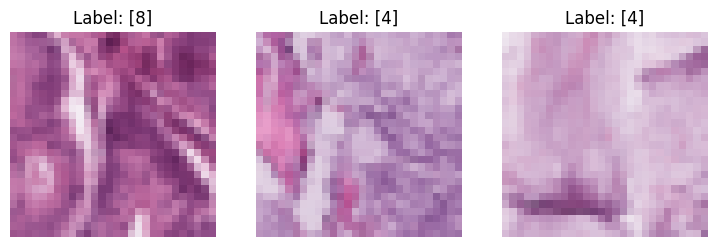

In [ ]:
import random
import matplotlib.pyplot as plt

rand_idx = [random.randint(0, len(pmnist_test)-1) for _ in range(3)]
rand_idx = [0,1,2]
X_samples = [pmnist_test[i][0].cpu().numpy() for i in rand_idx]
y_samples = [pmnist_test[i][1] for i in rand_idx]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i in range(3):
    img, label = X_samples[i], y_samples[i]

    img_rgb = img.transpose(1, 2, 0)  
    axes[i].imshow(img_rgb)
    
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()


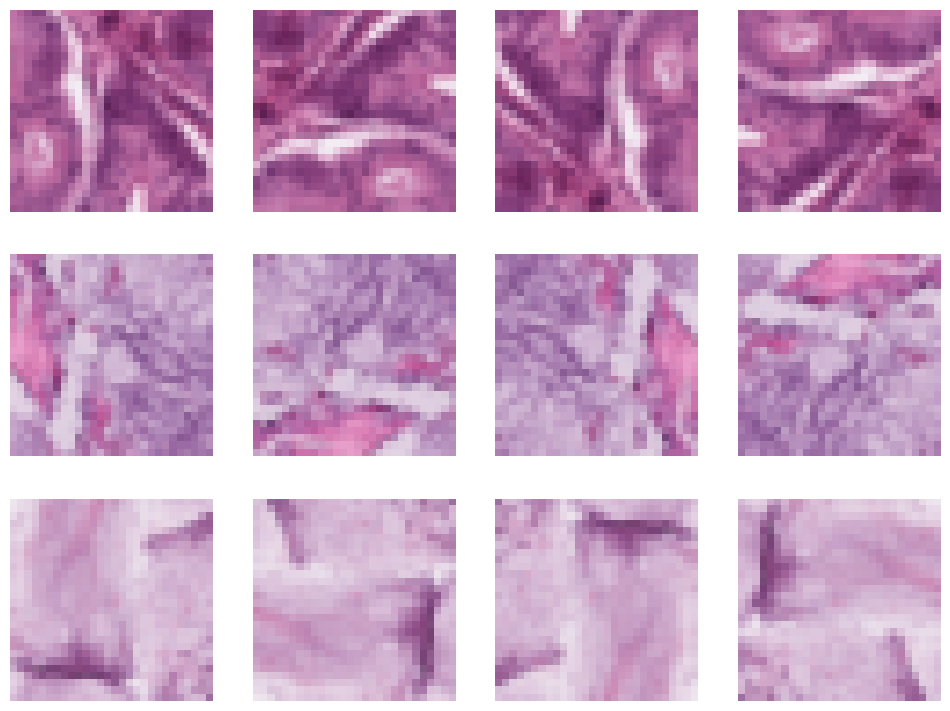

In [ ]:
# Rotations of samples
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

rotated_samples = {}  # store all rotations

for i, img in enumerate(X_samples):
    rotated_samples[i] = {}  # list to store all rotations
    for k in range(4):
        # rotate along H and W axes (axes 1 and 2)
        rot_img = np.rot90(img, k, axes=(1, 2))
        # transpose to HWC for imshow
        rot_img_HWC = rot_img.transpose(1, 2, 0)
        rotated_samples[i][k] = rot_img_HWC
        
        axes[i, k].imshow(rot_img_HWC)  # show the transposed image
        axes[i, k].axis('off')

In [11]:
# SimCLR
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_resnet18)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_resnet18)

acc_simclr, classifier_simclr = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8522284122562674


In [12]:
# EqCLR
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq)

acc_eqclr, classifier_eqclr = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.5952646239554318


In [13]:
# EqCLR N=8
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq_n8)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq_n8)

acc_eqclr_n8, classifier_eqclr_n8 = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.6224233983286908


In [14]:
# SimCLR without rotation
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_resnet18_wo_rotation)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_resnet18_wo_rotation)

acc_simclr_wo_rotation, classifier_simclr_wo_rotation = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8665738161559888


In [15]:
# EqCLR with rotation
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq_w_rotation)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq_w_rotation)

acc_eqclr_w_rotation, classifier_eqclr_w_rotation = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.6271587743732591


In [ ]:
for keys in rotated_samples.keys():
    samples = rotated_samples[keys]
    print(f"------------------ Sample {keys} ------------------")
    for rot in samples.keys():
        img = rotated_samples[keys][rot]
        img_tensor = torch.tensor(img.copy()).permute(2, 0, 1).unsqueeze(0).float().to(device)  # convert to tensor and add batch dimension
        
        # SimCLR
        #print(f"--------- SimCLR --------")
        with torch.no_grad():
            h, _ = model_resnet18(img_tensor)
        #z_np = h.to(device)
        y_pred = classifier_simclr(h)
        print(f"SimCLR - Predicted label: {y_pred.argmax()} -- True label: {y_samples[keys]}")

        # EqCLR
        #print(f"--------- EqCLR --------")
        with torch.no_grad():
            h_eq, _ = model_eq(img_tensor)
        # z_eq_np = h_eq.to(device)
        y_pred_eq = classifier_eqclr(h_eq)
        print(f"EqCLR -Predicted label: {y_pred_eq.argmax()} -- True label: {y_samples[keys]}")

------------------ Sample 0 ------------------
SimCLR - Predicted label: 7 -- True label: [8]
EqCLR -Predicted label: 8 -- True label: [8]
SimCLR - Predicted label: 2 -- True label: [8]
EqCLR -Predicted label: 2 -- True label: [8]
SimCLR - Predicted label: 7 -- True label: [8]
EqCLR -Predicted label: 7 -- True label: [8]
SimCLR - Predicted label: 7 -- True label: [8]
EqCLR -Predicted label: 7 -- True label: [8]
------------------ Sample 1 ------------------
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 8 -- True label: [4]
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 8 -- True label: [4]
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 2 -- True label: [4]
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 2 -- True label: [4]
------------------ Sample 2 ------------------
SimCLR - Predicted label: 7 -- True label: [4]
EqCLR -Predicted label: 5 -- True label: [4]
SimCLR - Predicted label: 7 -- 

In [17]:
import torchvision.transforms.functional as TF
import random

models = {
    "eqResnet18_N8": (model_eq_n8, classifier_eqclr_n8),
    "EqResnet18": (model_eq, classifier_eqclr),
    "EqResnet18 with rotation": (model_eq_w_rotation, classifier_eqclr_w_rotation),
    "Resnet18": (model_resnet18, classifier_simclr),
    "Resnet18 without rotation": (model_resnet18_wo_rotation, classifier_simclr_wo_rotation),
}
accuracies = {}

for model_name in models:
    model, classifier = models[model_name]
    accuracies[model_name] = {}

    with torch.no_grad():
        yhat = []
        y = []
        for batch_idx, batch in enumerate(DataLoader(pmnist_test, batch_size=1024)):
            images, labels = batch

            rotated_images = []
            for img in images:
                angle = random.choice([0, 90, 180, 270])
                img_rot = TF.rotate(img, angle)
                rotated_images.append(img_rot)

            rotated_images = torch.stack(rotated_images)

            h, z = model(rotated_images.to(device))
            logits = classifier(h)

            yhat.append(logits.cpu().numpy())
            y.append(labels.cpu().numpy().ravel())

        yhat = np.vstack(yhat)
        y = np.hstack(y)

    acc = (yhat.argmax(axis=1) == y).mean()
    accuracies[model_name]['Lin. acc. rotated data'] = acc
    print(f"Linear accuracy for {model_name}: {acc}", flush=True)


Linear accuracy for eqResnet18_N8: 0.623816155988858
Linear accuracy for EqResnet18: 0.5913649025069638
Linear accuracy for EqResnet18 with rotation: 0.6267409470752089
Linear accuracy for Resnet18: 0.8572423398328691
Linear accuracy for Resnet18 without rotation: 0.8661559888579388


In [18]:
import pandas as pd

accuracies['eqResnet18_N8']['Lin. acc. original data'] = acc_eqclr_n8
accuracies['EqResnet18']['Lin. acc. original data'] = acc_eqclr
accuracies['EqResnet18 with rotation']['Lin. acc. original data'] = acc_eqclr_w_rotation
accuracies['Resnet18']['Lin. acc. original data'] = acc_simclr
accuracies['Resnet18 without rotation']['Lin. acc. original data'] = acc_simclr_wo_rotation
accuracies_df = pd.DataFrame(accuracies).T
display(accuracies_df)

,Lin. acc. rotated data,Lin. acc. original data
eqResnet18_N8,0.623816,0.622423
EqResnet18,0.591365,0.595265
EqResnet18 with rotation,0.626741,0.627159
Resnet18,0.857242,0.852228
Resnet18 without rotation,0.866156,0.866574


In [19]:
import torchvision.transforms.functional as TF

models = {
    "eqResnet18_N8": (model_eq_n8, classifier_eqclr_n8),
    "EqResnet18": (model_eq, classifier_eqclr),
    "EqResnet18 with rotation": (model_eq_w_rotation, classifier_eqclr_w_rotation),
    "Resnet18": (model_resnet18, classifier_simclr),
    "Resnet18 without rotation": (model_resnet18_wo_rotation, classifier_simclr_wo_rotation),
}
consistencies = {}

for model_name in models:
    model, classifier = models[model_name]
    consistencies[model_name] = {}
    
    with torch.no_grad():
        y_hat = []
        y = []
        for angle in [0, 90, 180, 270]:
            yhat_angle = []
            y_angle = []
            for batch_idx, batch in enumerate(DataLoader(pmnist_test, batch_size=1024)):
                images, labels = batch

                rotated_images = []
                for img in images:
                    img_rot = TF.rotate(img, angle)
                    rotated_images.append(img_rot)

                rotated_images = torch.stack(rotated_images)

                h, z = model(rotated_images.to(device))
                logits = classifier(h)

                yhat_angle.append(logits.cpu().numpy())
                y_angle.append(labels.cpu().numpy().ravel())

            yhat_angle = np.vstack(yhat_angle)
            y_angle = np.hstack(y_angle)

            y_hat.append(yhat_angle.argmax(axis=1))
            y = y_angle

        acc = (yhat_angle.argmax(axis=1) == y_angle).mean()
        #accuracies[model_name]['Lin. acc. rotated data'] = acc
        print(f"Linear accuracy for {model_name} - rotation {angle}: {acc}", flush=True)

        # # compute consistency
        # consistent_mask = (y_hat[0] == y_hat[1]) & \
        #               (y_hat[0] == y_hat[2]) & \
        #               (y_hat[0] == y_hat[3])

        # consistency_percentage = consistent_mask.mean() * 100
        # print(f"Percentage of samples predicted the same across all rotations: {consistency_percentage:.2f}%")
            
        y_hat = np.vstack(y_hat).T  # shape (n_samples, 4)
        num_unique_preds = np.array([len(np.unique(p)) for p in y_hat])

        # Now compute percentages
        total_samples = len(num_unique_preds)
        percentages = {
            'all_same': (num_unique_preds == 1).sum() / total_samples * 100,
            '1 different': (num_unique_preds == 2).sum() / total_samples * 100,
            '2 different': (num_unique_preds == 3).sum() / total_samples * 100,
            'all different': (num_unique_preds == 4).sum() / total_samples * 100
        }
        consistencies[model_name] = percentages

        # Print nicely
        for k, v in percentages.items():
            print(f"{k}: {v:.2f}%")

Linear accuracy for eqResnet18_N8 - rotation 270: 0.6220055710306407
all_same: 42.69%
1 different: 40.50%
2 different: 14.85%
all different: 1.96%
Linear accuracy for EqResnet18 - rotation 270: 0.5966573816155989
all_same: 41.45%
1 different: 39.36%
2 different: 16.64%
all different: 2.55%
Linear accuracy for EqResnet18 with rotation - rotation 270: 0.6176880222841226
all_same: 40.99%
1 different: 40.31%
2 different: 16.45%
all different: 2.26%
Linear accuracy for Resnet18 - rotation 270: 0.8577994428969359
all_same: 87.65%
1 different: 11.45%
2 different: 0.86%
all different: 0.04%
Linear accuracy for Resnet18 without rotation - rotation 270: 0.8615598885793871
all_same: 83.50%
1 different: 15.08%
2 different: 1.36%
all different: 0.06%


In [21]:
import pandas as pd

consistencies_df = pd.DataFrame(consistencies).T
display(consistencies_df)

,all_same,1 different,2 different,all different
eqResnet18_N8,42.688022,40.501393,14.846797,1.963788
EqResnet18,41.448468,39.359331,16.643454,2.548747
EqResnet18 with rotation,40.988858,40.306407,16.448468,2.256267
Resnet18,87.646240,11.448468,0.863510,0.041783
Resnet18 without rotation,83.495822,15.083565,1.364903,0.055710


# t-SNE

In [23]:
list_h_eq = []
list_h_res = []
labels_list = []

test_loader = DataLoader(pmnist_test, batch_size=128, shuffle=False)


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        h_eq, _ = model_eq_n8(images)
        h_res, _ = model_resnet18(images) 

        list_h_eq.append(h_eq.cpu())
        list_h_res.append(h_res.cpu())
        labels_list.append(labels)

all_h_eq = torch.cat(list_h_eq, dim=0).numpy()
all_h_res = torch.cat(list_h_res, dim=0).numpy()
all_labels = torch.cat(labels_list, dim=0).numpy()

In [24]:
from openTSNE import TSNE

tsne_eq = TSNE()
eq_emb = tsne_eq.fit(all_h_eq)

tsne_res = TSNE()
res_emb = tsne_res.fit(all_h_res)

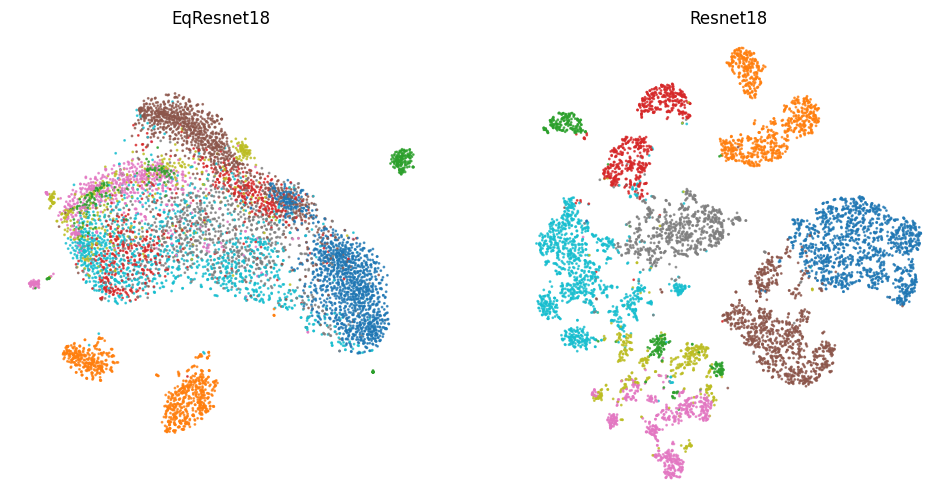

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# EqCLR plot
scatter_eq = ax[0].scatter(eq_emb[:, 0], eq_emb[:, 1], c=all_labels, cmap='tab10', s=1, alpha=0.75)
ax[0].set_title('EqResnet18')

# SimCLR plot
scatter_res = ax[1].scatter(res_emb[:, 0], res_emb[:, 1], c=all_labels, cmap='tab10', s=1, alpha=0.75)
ax[1].set_title('Resnet18')

for a in ax:
    a.axis('off')
    a.axis('equal')
